# Air traffic prediction by airline for San Francisco airport

In [32]:
import pandas as pd

# Load data
data = pd.read_csv("air-traffic-landings-statistics.csv")

data.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,201809,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Passenger,Regional Jet,Bombardier,CRJ2,-,30,1410000
1,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Narrow Body,Airbus,A320,-,125,17787978
2,201809,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Passenger,Wide Body,Boeing,B773,-,30,16620000
3,201809,"COPA Airlines, Inc.",CM,"COPA Airlines, Inc.",CM,International,Central America,Passenger,Narrow Body,Boeing,B739,-,3,491700
4,201809,Hong Kong Airlines Limited,HX,Hong Kong Airlines Limited,HX,International,Asia,Passenger,Wide Body,Airbus,A359,-,16,7301712


## Air Canada as the Specific Airline

In [40]:
# Filter data for a specific airline
airline_data = data[data['Operating Airline'] == 'Air Canada']

airline_data.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
1,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Narrow Body,Airbus,A320,-,125,17787978
37,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Narrow Body,Airbus,A321,-,20,3430400
40,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Wide Body,Boeing,B773,-,4,2216000
110,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Wide Body,Boeing,B789,-,43,18275000
119,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Narrow Body,Airbus,A319,-,4,537928


In [42]:
airline_data.describe()

,Activity Period,Landing Count,Total Landed Weight
count,829.000000,829.000000,8.290000e+02
mean,201209.431846,49.817853,7.033536e+06
std,373.066337,49.745554,6.557076e+06
min,200507.000000,1.000000,9.700000e+04
25%,200905.000000,8.000000,1.137600e+06
50%,201209.000000,32.000000,5.659500e+06
75%,201509.000000,82.000000,1.055670e+07
max,201809.000000,254.000000,3.615798e+07


In [44]:
# Aggregate data by Activity Period
airline_data_grouped = airline_data.groupby('Activity Period').agg(
    LandingCount=('Landing Count', 'sum'),
    TotalWeight=('Total Landed Weight', 'sum')
).reset_index()

# Ensure Activity Period is sorted
airline_data_grouped = airline_data_grouped.sort_values('Activity Period')

In [48]:
airline_data_grouped.head()

,Activity Period,LandingCount,TotalWeight
0,200507,309,42944240
1,200508,303,41758020
2,200509,231,31935160
3,200510,215,29755580
4,200511,180,25128040


## Feature Engineering

In [53]:
# Convert 'Activity Period' to datetime
airline_data_grouped['Activity Period'] = pd.to_datetime(
    airline_data_grouped['Activity Period'], format='%Y%m'
)

## Extract Year, Month, and Quarter

In [56]:
# Extract features
airline_data_grouped['Year'] = airline_data_grouped['Activity Period'].dt.year
airline_data_grouped['Month'] = airline_data_grouped['Activity Period'].dt.month
airline_data_grouped['Quarter'] = airline_data_grouped['Activity Period'].dt.quarter

## lag features
creating lag features, which are values of the target variable (LandingCount) from previous time periods.to help the model learn patterns over time. historical information about LandingCount
Lag features help capture the temporal dependencies.
- Lag1 represents the LandingCount from one period before the current one.
- Lag2 represents the LandingCount from two periods before the current one.

In [62]:
# Create lag features for Landing Count
airline_data_grouped['Lag1'] = airline_data_grouped['LandingCount'].shift(1)
airline_data_grouped['Lag2'] = airline_data_grouped['LandingCount'].shift(2)

In [64]:
airline_data_grouped.head()

,Activity Period,LandingCount,TotalWeight,Year,Month,Quarter,Lag1,Lag2
0,2005-07-01,309,42944240,2005,7,3,NaN,NaN
1,2005-08-01,303,41758020,2005,8,3,309.0,NaN
2,2005-09-01,231,31935160,2005,9,3,303.0,309.0
3,2005-10-01,215,29755580,2005,10,4,231.0,303.0
4,2005-11-01,180,25128040,2005,11,4,215.0,231.0


In [68]:
# Drop rows with NaN values (due to lag features) the first 2 ligns
airline_data_grouped = airline_data_grouped.dropna()

# Features and target
X = airline_data_grouped[['Year', 'Month', 'Quarter', 'Lag1', 'Lag2']]
y = airline_data_grouped['LandingCount']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Prediction Model
### Option 1: Machine Learning RandomForest

In [112]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 25.090804528252978


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Option 2: Time-Series Models ARIMA

In [80]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model (order=(p,d,q) needs tuning)
time_series = airline_data_grouped.set_index('Activity Period')['LandingCount']
model = ARIMA(time_series, order=(1, 1, 1))  # Adjust p, d, q
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)
print(forecast)

2018-10-01    319.909127
2018-11-01    316.829186
2018-12-01    315.785717
2019-01-01    315.432195
2019-02-01    315.312424
2019-03-01    315.271846
2019-04-01    315.258098
2019-05-01    315.253441
2019-06-01    315.251863
2019-07-01    315.251328
2019-08-01    315.251147
2019-09-01    315.251085
Freq: MS, Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### prophet 

In [ ]:
pip install prophet

14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing


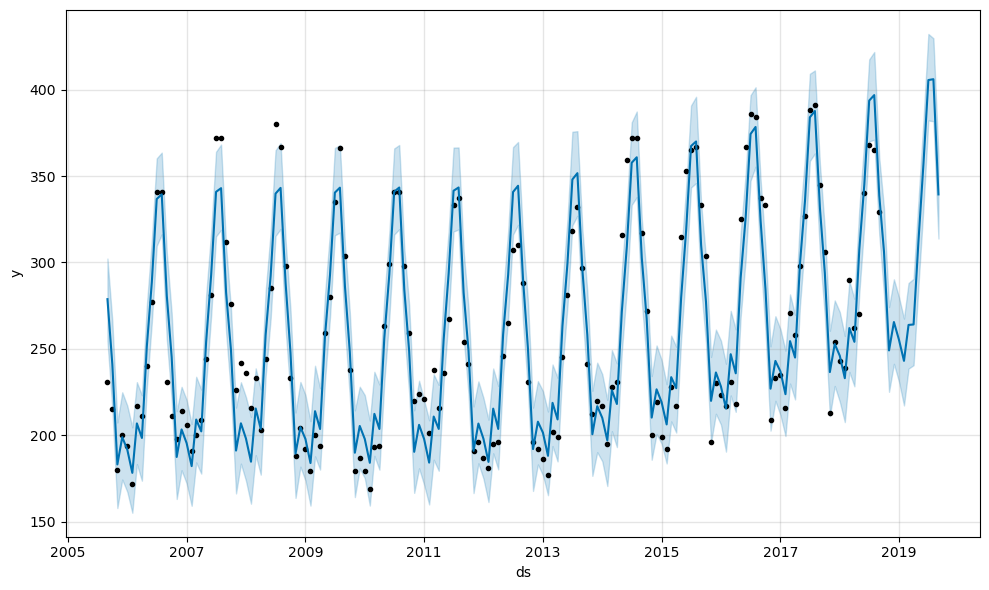

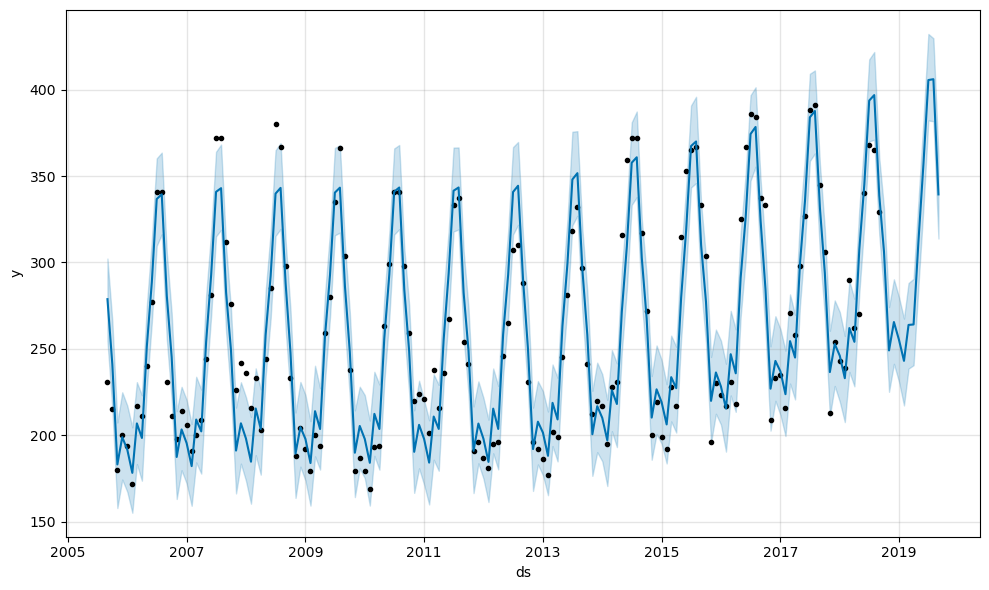

In [125]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = airline_data_grouped[['Activity Period', 'LandingCount']].rename(
    columns={'Activity Period': 'ds', 'LandingCount': 'y'}
)

# Train model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Predict for future months
future = prophet_model.make_future_dataframe(periods=12, freq='ME')
forecast = prophet_model.predict(future)
prophet_model.plot(forecast)

## Visualize Predictions

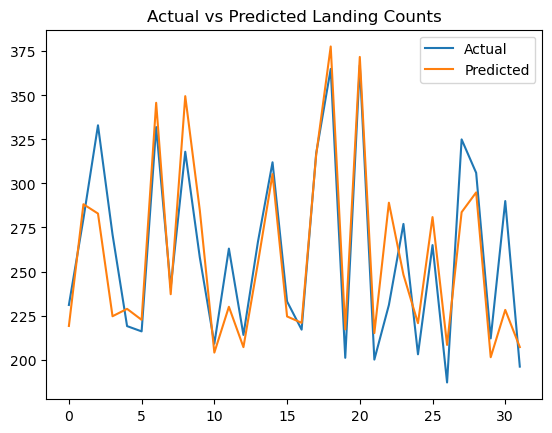

In [127]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for Random Forest
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Landing Counts")
plt.show()

In [121]:
# Create a future DataFrame
future_periods = pd.date_range(start=airline_data_grouped['Activity Period'].max(), periods=12, freq='ME')
future_df = pd.DataFrame({
    'Year': future_periods.year,
    'Month': future_periods.month,
    'Quarter': (future_periods.month % 12) // 3 + 1,
    'Lag1': airline_data_grouped['LandingCount'].iloc[-1],  # Use most recent lag values
    'Lag2': airline_data_grouped['LandingCount'].iloc[-2]
})

# Predict future traffic
future_predictions = model.predict(future_df)
print(future_predictions)

[297.17 279.56 246.19 267.55 327.27 327.27 327.46 327.46 327.94 364.55
 366.72 363.08]


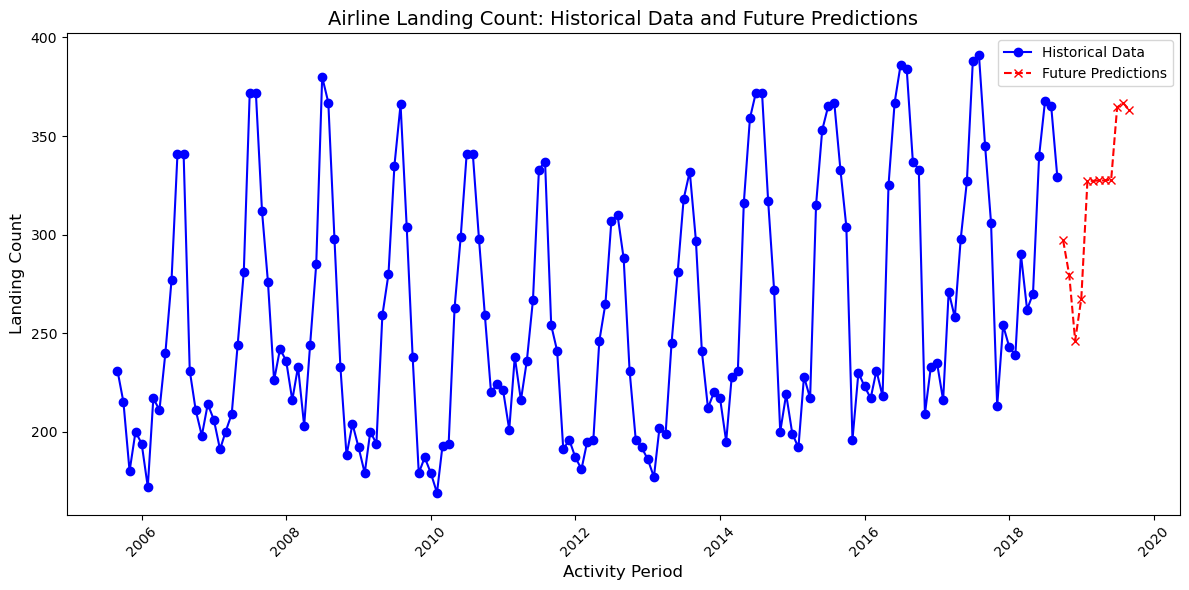

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have 'airline_data_grouped' and 'future_predictions' defined
# Create a future period DataFrame for visualization
future_periods = pd.date_range(start=airline_data_grouped['Activity Period'].max(), periods=12, freq='ME')
future_df = pd.DataFrame({
    'Activity Period': future_periods,
    'LandingCount': future_predictions
})

# Create a combined DataFrame for both historical and future data
combined_data = pd.concat([airline_data_grouped[['Activity Period', 'LandingCount']], future_df], ignore_index=True)

# Plot the historical and future landing counts
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(airline_data_grouped['Activity Period'], airline_data_grouped['LandingCount'], label='Historical Data', color='blue', marker='o')

# Plot future predictions
plt.plot(future_df['Activity Period'], future_df['LandingCount'], label='Future Predictions', color='red', linestyle='--', marker='x')

# Add labels and title
plt.title('Airline Landing Count: Historical Data and Future Predictions', fontsize=14)
plt.xlabel('Activity Period', fontsize=12)
plt.ylabel('Landing Count', fontsize=12)

# Format x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.show()
